http://implicit-layers-tutorial.org/neural_odes/

In [1]:
import jax.numpy as jnp
from jax import jit, grad

A simple deep neural net --  simply a composition of linear and nonlinear layers.

In [2]:
def mlp(params, inputs):
  # A multi-layer perceptron, i.e. a fully-connected neural network.
  for w, b in params:
    outputs = jnp.dot(inputs, w) + b  # Linear transform
    inputs = jnp.tanh(outputs)        # Nonlinearity
  return outputs

To make larger models, we can always chain together or compose layers. 

As a standard example, chaining together some smaller neural networks, such as mlp layers, adding each one’s input to its output, is called a residual network:

In [3]:
def resnet(params, inputs, depth):
  for _ in range(depth):
    outputs = mlp(params, inputs) + inputs
  return outputs


To fit this model to data, we also need a loss, an initializer, and an optimizer:

In [4]:
import numpy.random as npr
from jax import jit, grad

resnet_depth = 3

def resnet_squared_loss(params, inputs, targets):
  preds = resnet(params, inputs, resnet_depth)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

# A simple gradient-descent optimizer.
@jit
def resnet_update(params, inputs, targets):
  grads = grad(resnet_squared_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]



let’s fit our resnet to a toy 1D dataset (green circles) and plot the predictions of the trained model (blue curve):

In [5]:
# Toy 1D dataset.
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
targets = inputs**3 + 0.1 * inputs

2024-03-13 14:15:19.081486: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Text(0, 0.5, 'output')

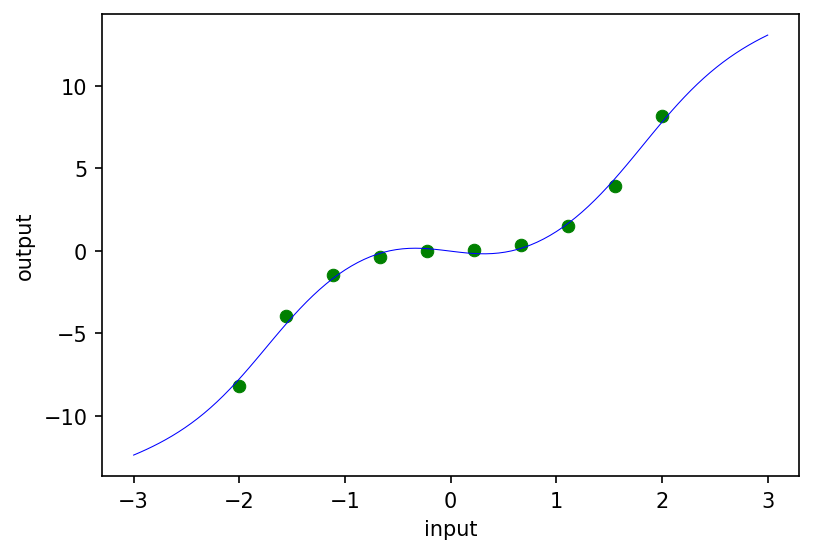

In [6]:
# Hyperparameters.
layer_sizes = [1, 20, 1]
param_scale = 1.0
step_size = 0.01
train_iters = 1000

# Initialize and train.
resnet_params = init_random_params(param_scale, layer_sizes)
for i in range(train_iters):
  resnet_params = resnet_update(resnet_params, inputs, targets)

# Plot results.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.set_xlabel('input')
ax.set_ylabel('output')

### Builiding a neural ODE

Similar to a residual network, a neural ODE (or ODE-Net) takes a simple layer as a building block, and chains many copies of it together to buld a bigger model. In particular, our “base layer” is going to specify the dynamics of an ODE, and we’re going to chain the output of these base layers together according to the logic on an ODE solver.

an ODE ivp has the form \
$\dot{\mathbf{y}}(t) = \mathbf{f}(\mathbf{y}(t), t, \mathsf{\mathbf{\theta}})$ where the state-space $\mathbf{y} \in \mathbb{R}^n$ and parameters space  $\mathbf{\theta} \in \mathbb{R}^k$.  So the dynmics function has the dimensions $\mathbf{f}: \mathbb{R}^n \times \mathbb{R} \times \mathbb{R}^k $. We need the dynamics function $\mathbf{f}$ to take in the **current** state $\mathbf{y}(t)$ of the ODE, the **current** time, and some params $\mathbf{\theta}$, and output $\frac{\partial \mathbf{y}}{\partial t}$ that $\in \mathbb{R}^n$.

We can easily build such a function by simply concatenating the state and current time, and sending that as the input to mlp. (Now the inputs are  `[current_state, current_time]`)

In [7]:
def nn_dynamics(state, time, params):
  state_and_time = jnp.hstack([state, jnp.array(time)])
  return mlp(params, state_and_time)


In [8]:
from jax.experimental.ode import odeint

def odenet(params, input):
  start_and_end_times = jnp.array([0.0, 1.0])
  init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params)
  return final_state


### Batching an ODE Net

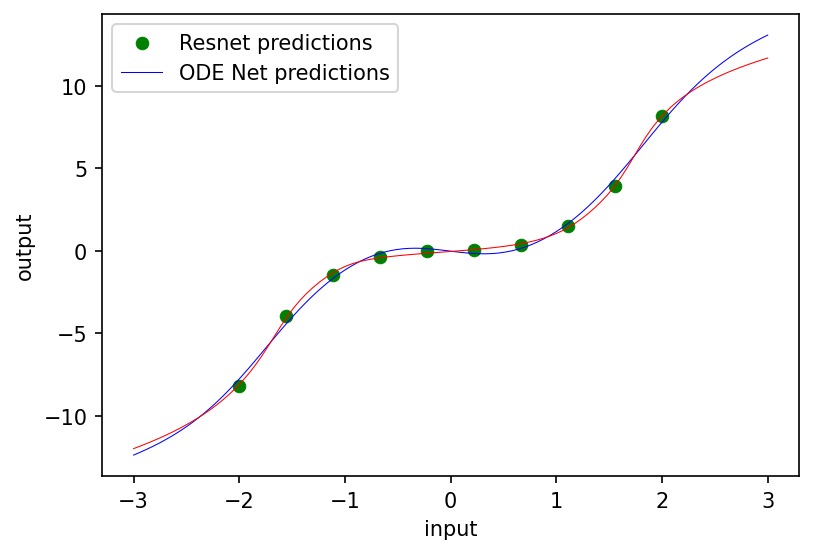

In [9]:
from jax import vmap
batched_odenet = vmap(odenet, in_axes=(None, 0))
# We need to change the input dimension to 2, to allow time-dependent dynamics.
odenet_layer_sizes = [2, 20, 1]

def odenet_loss(params, inputs, targets):
  preds = batched_odenet(params, inputs)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

@jit
def odenet_update(params, inputs, targets):
  grads = grad(odenet_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

# Initialize and train ODE-Net.
odenet_params = init_random_params(param_scale, odenet_layer_sizes)

for i in range(train_iters):
  odenet_params = odenet_update(odenet_params, inputs, targets)

# Plot resulting model.
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.plot(fine_inputs, batched_odenet(odenet_params, fine_inputs), lw=0.5, color='red')
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(('Resnet predictions', 'ODE Net predictions'))
